# Manually finetuned version of the cnn 

Parameters tuned:

- added batch normalisation
- changed layers from (32,32,64) -> (32,64,128)
- changed input size from 224 -> 250
- GlobalAveragePooling2D instead of Flatten
- added additional dropout after Dense-Layer
- Changed from 12 rotations/reflections to 8 to avoid duplicate images

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
print(tf.__version__) # check for 2.19.0


2.19.0


# Train-Test Split
80% - 20%

momentan insgesamt je 300 Bilder --> dh. 240 für Training, 60 Testing

# Loading data

In [2]:
labels = ['no', 'yes'] # yes: green electro parking spot
# 'no' = 0, 'yes' = 1
img_size = 250  # Zielgrösse Bilder  224         

def get_data(data_dir):
    X = []  # Bilddaten
    y = []  # zugehörigen Labels 0 oder 1 

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]    # Bild einlesen, in RGB umwandeln 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Bild auf einheitliche Grösse skalieren
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(f"Fehler bei {img}: {e}")

    return np.array(X), np.array(y)

In [ ]:
# alle Daten laden 
train_X, train_y = get_data('data_split/train')   # X=Bild, y=Label 
val_X, val_y = get_data('data_split/test')        # 0 für no, 1 für yes

print("Train shape:", train_X.shape, train_y.shape)
print("Val shape:", val_X.shape, val_y.shape)

# Beispiel-Labels anzeigen 
print("\nLabel-Beispiel1:", train_y[0], "→", labels[train_y[0]])
print("Label-Beispiel2:", train_y[-1], "→", labels[train_y[-1]])

# Anzahl Daten
print("\nLänge Trainingsdaten:", len(train_X))   # hier 480 Bilder
print("Länge Labels:", len(train_y))   # sollte genauso viele Labels haben wie train_X


Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480


# Visualize data

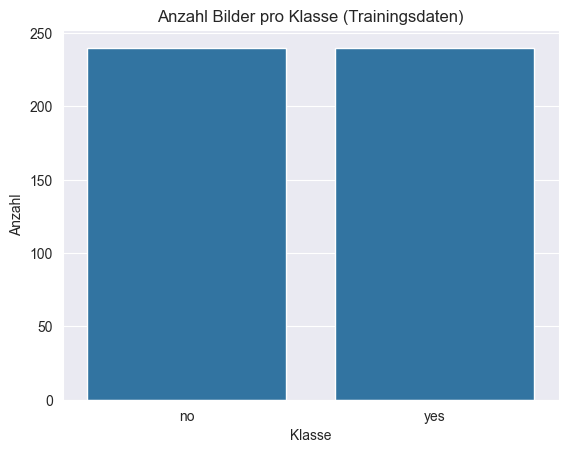

In [4]:
l = []
for i in train_y:   # train_y sind Labels 0 oder 1 
    if i == 0:
        l.append("no")
    else:
        l.append("yes")
        
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.title("Anzahl Bilder pro Klasse (Trainingsdaten)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl")
plt.show()

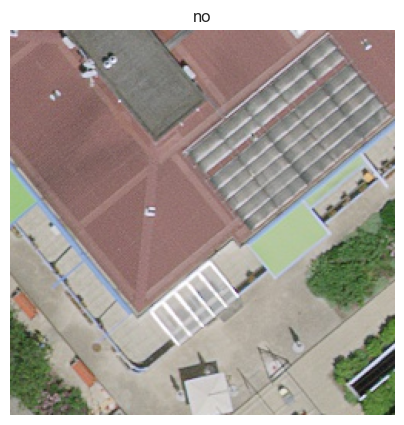

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train_X[0])  # Bilddaten, hier z.B. erstes Bild 
plt.title(labels[train_y[0]])   # Klassentext: yes or no 
plt.axis('off')
plt.show()

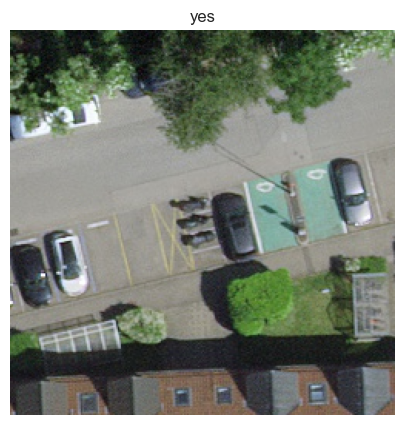

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(train_X[240]) # 241. Bild im Datensatz = 1. yes Bild 
plt.title(labels[train_y[-1]])  # Label anzeigen: yes or no 
plt.axis('off')
plt.show()

# Data Preprocessing and Data Augmentation 

In [7]:
# Bilder drehen und spiegel aus 1 Orginalbild -> 12 Testbilder 
def rotate_and_flip_images(x, y):
    x_aug, y_aug = [], []
    for img, label in zip(x, y):
        for k in range(4):  # 0°, 90°, 180°, 270°
            rotated = np.rot90(img, k=k)
            x_aug.append(rotated); y_aug.append(label)
            x_aug.append(np.fliplr(rotated)); y_aug.append(label)  # Horizontal Flip
            #x_aug.append(np.flipud(rotated)); y_aug.append(label)  # Vertical Flip
    return np.array(x_aug), np.array(y_aug)

In [8]:
# Augmentieren: Drehen und Flippen
x_train, y_train = rotate_and_flip_images(train_X, train_y)

# Normalisieren --> Pixelwerte von 0-255 enspricht 0-1
x_train = x_train / 255.0
x_val = val_X / 255.0

# Labels als float32 für binary_crossentropy
y_train = y_train.astype('float32')
y_val = val_y.astype('float32')

# Kontrolle
print("Train X:", x_train.shape)    # 480 Originalbilder *12 = 5760
print("Train y:", y_train.shape)
print("Val X:", x_val.shape)        # 120 echte Testbilder 
print("Val y:", y_val.shape)
print(set(y_train))

Train X: (3840, 250, 250, 3)
Train y: (3840,)
Val X: (120, 250, 250, 3)
Val y: (120,)
{np.float32(0.0), np.float32(1.0)}


# Define the Model

In [9]:
model = Sequential()

# 1. Convolutional Layer
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(224, 224, 3)))
model.add(BatchNormalization())  # Normalize after convolution
model.add(MaxPool2D())

# 2. Convolutional Layer
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())  # Normalize after convolution
model.add(MaxPool2D())

# 3. Convolutional Layer + Dropout to prevent overfitting
model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())  # Normalize after convolution
model.add(MaxPool2D())
model.add(Dropout(0.4))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())  # Reduces the size of the output (fewer parameters)

# Dense Layer
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output Layer (Sigmoid for binary classification)
model.add(Dense(1, activation="sigmoid"))

# Model Summary
model.summary()

# Optimizer and Callbacks
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate for better convergence
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Compile the Model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Optimizer 
opt = Adam(learning_rate=0.0001)   # Lernrate gibt an wie stark Modell seine Gewichte anpasst 

# Modell kompilieren 
model.compile(
    optimizer = opt, 
    loss = 'binary_crossentropy',   # für 2-Klassen Probleme 
    metrics = ['accuracy'])

# Training 
history = model.fit(
    x_train, y_train,
    batch_size = 16, # 32 
    epochs = 50,    # max. 50 Runden 
    validation_data = (x_val, y_val),   # für Modellbewertung 
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]  # beendet Training, wenn sich val_loss 5 Epochen lang nicht mehr verbessert -> verhindert Overfitting 
)


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 214s 876ms/step - accuracy: 0.6324 - loss: 0.6398 - val_accuracy: 0.5000 - val_loss: 0.7267
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 210s 874ms/step - accuracy: 0.7374 - loss: 0.5316 - val_accuracy: 0.5000 - val_loss: 0.8190
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 805ms/step - accuracy: 0.7857 - loss: 0.4553 - val_accuracy: 0.8250 - val_loss: 0.4288
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 178s 742ms/step - accuracy: 0.8288 - loss: 0.3966 - val_accuracy: 0.8000 - val_loss: 0.4235
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 170s 709ms/step - accuracy: 0.8369 - loss: 0.3782 - val_accuracy: 0.8583 - val_loss: 0.3606
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 170s 709ms/step - accuracy: 0.8600 - loss: 0.3426 - val_accuracy: 0.8917 - val_loss: 0.3154
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 172s 715ms/step - accuracy: 0.8733 - loss: 0.3110 - val_accuracy: 0.8333 - val_loss: 0.3645
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 168s 701ms/step - accuracy: 0.8904 -

# Evaluating results

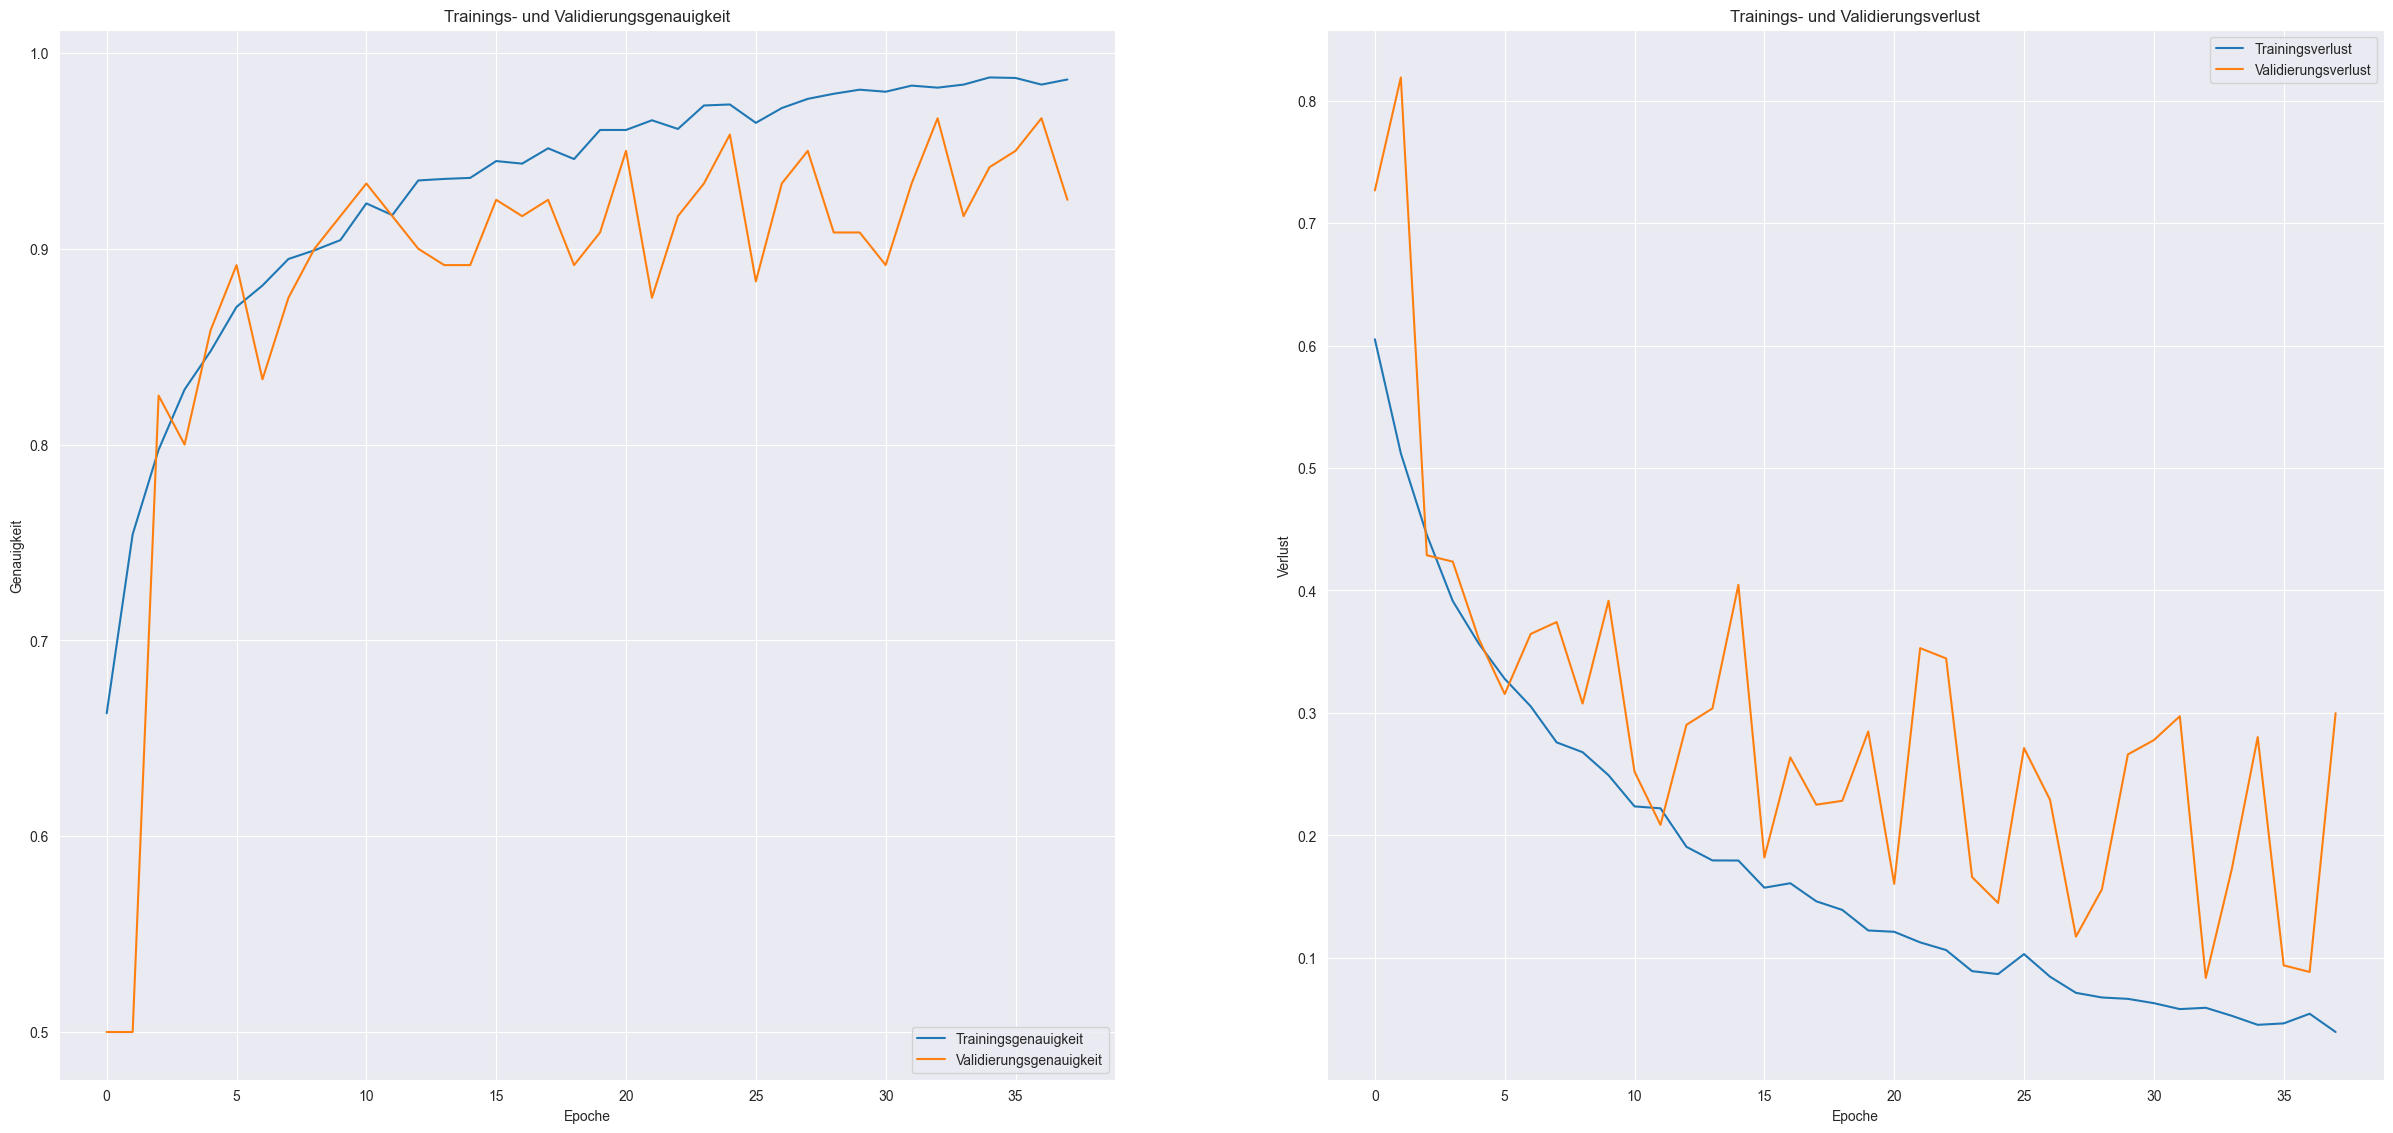

In [ ]:
import matplotlib.pyplot as plt

# save model
model.save('cnn_v_2.keras')  # Speichern des Modells

# Trainingsverlauf aus dem History-Objekt auslesen
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Automatisch richtige Länge der x-Achse
epochs_range = range(len(acc))

# Plot erstellen
plt.figure(figsize=(30, 30))

# Accuracy-Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
plt.legend(loc='lower right')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')

# Loss-Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Trainingsverlust')
plt.plot(epochs_range, val_loss, label='Validierungsverlust')
plt.legend(loc='upper right')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')

plt.show()


In [12]:
# Vorhersagen (Wahrscheinlichkeiten zwischen 0 und 1)
predictions = model.predict(x_val)

# Schwelle: ab 0.5 → Klasse 1 (ja = grüner Parkplatz), sonst Klasse 0
predictions = (predictions > 0.5).astype("int32").reshape(-1)

# Klassifikationsbericht anzeigen
print(classification_report(y_val, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.94      1.00      0.97        60
grüner E-Parkplatz (1)       1.00      0.93      0.97        60

              accuracy                           0.97       120
             macro avg       0.97      0.97      0.97       120
          weighted avg       0.97      0.97      0.97       120



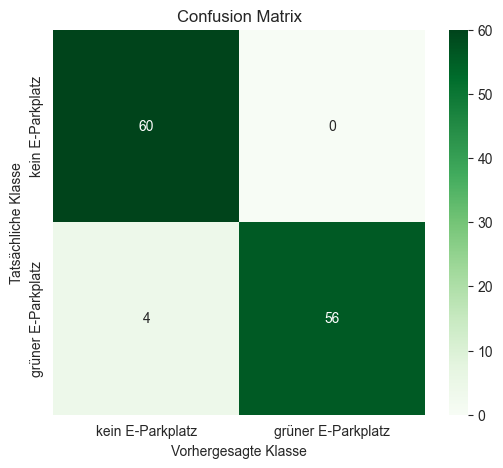

In [13]:
# Confusion Matrix berechnen
cm = confusion_matrix(y_val, predictions)

# Klassenbezeichnungen
labels = ['kein E-Parkplatz', 'grüner E-Parkplatz']

# Plot anzeigen
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Vorhergesagte Klasse')  
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix')
plt.show()
# TN    FP
# FN    TP